## efficient Net モデル

In [ ]:
%cd /media/deepstation/Transcend/learning/UC/model_efficientnet

/media/deepstation/Transcend/learning/UC/model_efficientnet


In [ ]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#import efficientnet.tfkeras as enet
import keras_efficientnets as enet

import os, cv2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
#from keras.layers.core import Dense
from keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras import models, optimizers, layers
from tensorflow.keras.optimizers import SGD
from keras.layers import Flatten
from sklearn.model_selection import train_test_split  
from PIL import Image 
from tensorflow.keras.preprocessing import image as images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K 
import numpy as np  
import glob  
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import roc_curve
import requests


### １

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Low","High"]
model_number = 4

#エポック、バッチサイズ
epochs = 15
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 1
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_1_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_1_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_1
learning_1_data_6_train_set_1.h5
learning_1_data_6_train_set_1.json
/media/deepstation/Transcend/save/learning_1_data_6_train_set_1_20201207
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 190, 190, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 190, 190, 48) 192         conv2d[0][0]                     
_______________________________________________________________________________________________

### 2

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Preserve","Disturb"]
model_number = 4

#エポック、バッチサイズ
epochs = 7
batch_size = 4

#learning_num, data_set
learnig_num = 2
data_num = 6
train_set_num = 2
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_2_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_2_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_2
learning_2_data_6_train_set_2.h5
learning_2_data_6_train_set_2.json
/media/deepstation/Transcend/save/learning_2_data_6_train_set_2_20201207
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 190, 190, 48) 1296        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 190, 190, 48) 192         conv2d_128[0][0]                 
_______________________________________________________________________________________________

### 3

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Small","Large"]
model_number = 4

#エポック、バッチサイズ
epochs = 10
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 3
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_3_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_3_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_3
learning_1_data_6_train_set_3.h5
learning_1_data_6_train_set_3.json
/media/deepstation/Transcend/save/learning_1_data_6_train_set_3_20201207
Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d_256 (Conv2D)             (None, 190, 190, 48) 1296        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_198 (BatchN (None, 190, 190, 48) 192         conv2d_256[0][0]                 
______________________________________________________________________________________________

### 4

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Various","Similar"]
model_number = 4

#エポック、バッチサイズ
epochs = 10
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 4
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_4_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_4_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_4
learning_1_data_6_train_set_4.h5
learning_1_data_6_train_set_4.json
/media/deepstation/Transcend/save/learning_1_data_6_train_set_4_20201207
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d_384 (Conv2D)             (None, 190, 190, 48) 1296        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_297 (BatchN (None, 190, 190, 48) 192         conv2d_384[0][0]                 
______________________________________________________________________________________________

### 5

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Negative","Positive"]
model_number = 4

#エポック、バッチサイズ
epochs = 10
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 5
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_5_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_5_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_5
learning_1_data_6_train_set_5.h5
learning_1_data_6_train_set_5.json
/media/deepstation/Transcend/save/learning_1_data_6_train_set_5_20201207
Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d_512 (Conv2D)             (None, 190, 190, 48) 1296        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_396 (BatchN (None, 190, 190, 48) 192         conv2d_512[0][0]                 
______________________________________________________________________________________________

### 6

In [ ]:
#******************************************************************************
#クラスの数、クラスの名前、学習画像のサイズ    
num_classes = 2
folder = ["Oval","Round"]
model_number = 4

#エポック、バッチサイズ
epochs = 7
batch_size = 4

#learning_num, data_set
learnig_num = 1
data_num = 6
train_set_num = 6
day = 20201207

#validationの合計数
#val_num = 160

#augmention
augmention = False

#******************************************************************************
if model_number == 0:
    image_size = 224
elif model_number == 1:
    image_size = 240
elif model_number == 2:
    image_size = 260
elif model_number == 3:
    image_size = 300
elif model_number == 4:
    image_size = 380
elif model_number == 5:
    image_size = 456
elif model_number == 6:
    image_size = 528
elif model_number == 7:
    image_size = 600
else:
    print('set model_number 0 to 7')
    
#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/" + "data_" + str(data_num) + "/train_" +  str(train_set_num)
print(data_path)
#モデルの名前
model_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_name)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
validation_path = data_path + "/validation/"
testing_path = data_path + "/testing/"

from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

model.summary()


# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_loss{val_loss:.3f}.hdf5",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)
# log for TensorBoard
logging = TensorBoard(log_dir="log/")

mcp_save = ModelCheckpoint('/content/drive/My Drive/UC/model_EfficientNet/EnetB7_CIFAR10_TL.h5', save_best_only=False)

#model.load_weights(model_name)

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


model_6_1 = Model(model.get_layer(index=0).input, model.get_layer(index=-2).output)
#model_6_2 = Model(model.get_layer(index=0).input, model.get_layer(index=-1).output)

/media/deepstation/Transcend/data/data_6/train_6
learning_1_data_6_train_set_6.h5
learning_1_data_6_train_set_6.json
/media/deepstation/Transcend/save/learning_1_data_6_train_set_6_20201207
Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
conv2d_640 (Conv2D)             (None, 190, 190, 48) 1296        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_495 (BatchN (None, 190, 190, 48) 192         conv2d_640[0][0]                 
______________________________________________________________________________________________

## 統合モデル①

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import time
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet import *
#******************************************************************************
#クラスの数、クラスの名前
num_classes = 4
folder = ["Normal","Atypical","Dysplasia","CIS"]

#学習画像のサイズ                                     
model_number = 4

#エポック、バッチサイズ
epochs = 15
batch_size = 4
save_timing = 5

#使用する学習セット
data_num = 2

train_set_num = 1
base_set_num = 2

#validationの合計数
#val_num = 160

#学習ナンバー
learnig_num = 100
day = 20201222

#******************************************************************************

#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(train_set_num)
print(data_path)
#モデルの名前
model_naming = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_naming)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#CVSの名前
cvs_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".cvs"
print(cvs_name)

#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
base_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(base_set_num) 
validation_path = data_path+ "/validation/"
testing_path = data_path + "/testing/"




/media/deepstation/Transcend/data/data_2/train_1
learning_3_data_2_train_set_1.h5
learning_3_data_2_train_set_1.json
learning_3_data_2_train_set_1.cvs
/media/deepstation/Transcend/save/learning_3_data_2_train_set_1_20201222


In [ ]:
from keras.backend import sigmoid
from random import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
import numpy as np

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
# 入力を定義
input1 = Input(shape=(128,))
input2 = Input(shape=(128,))
input3 = Input(shape=(128,))
input4 = Input(shape=(128,))
input5 = Input(shape=(128,))
input6 = Input(shape=(128,))

# 入力1から結合前まで
x1 = Dense(128, activation="linear")(input1)
x1 = Model(inputs=input1, outputs=x1)

# 入力2から結合前まで
x2 = Dense(128, activation="linear")(input2)
x2 = Model(inputs=input2, outputs=x2)

# 入力2から結合前まで
x3 = Dense(128, activation="linear")(input3)
x3 = Model(inputs=input3, outputs=x3)

# 入力1から結合前まで
x4 = Dense(128, activation="linear")(input4)
x4 = Model(inputs=input4, outputs=x4)

# 入力2から結合前まで
x5 = Dense(128, activation="linear")(input5)
x5 = Model(inputs=input5, outputs=x5)

# 入力2から結合前まで
x6 = Dense(128, activation="linear")(input6)
x6 = Model(inputs=input6, outputs=x6)

# 結合
combined = concatenate([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output])

# 密結合
x = Dense(512)(combined)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

predictions = Dense(4, activation="softmax")(x)
model = Model(inputs = [x1.input, x2.input, x3.input, x4.input, x5.input, x6.input], outputs = predictions)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128)]        0                                            
______________________________________________________________________________________

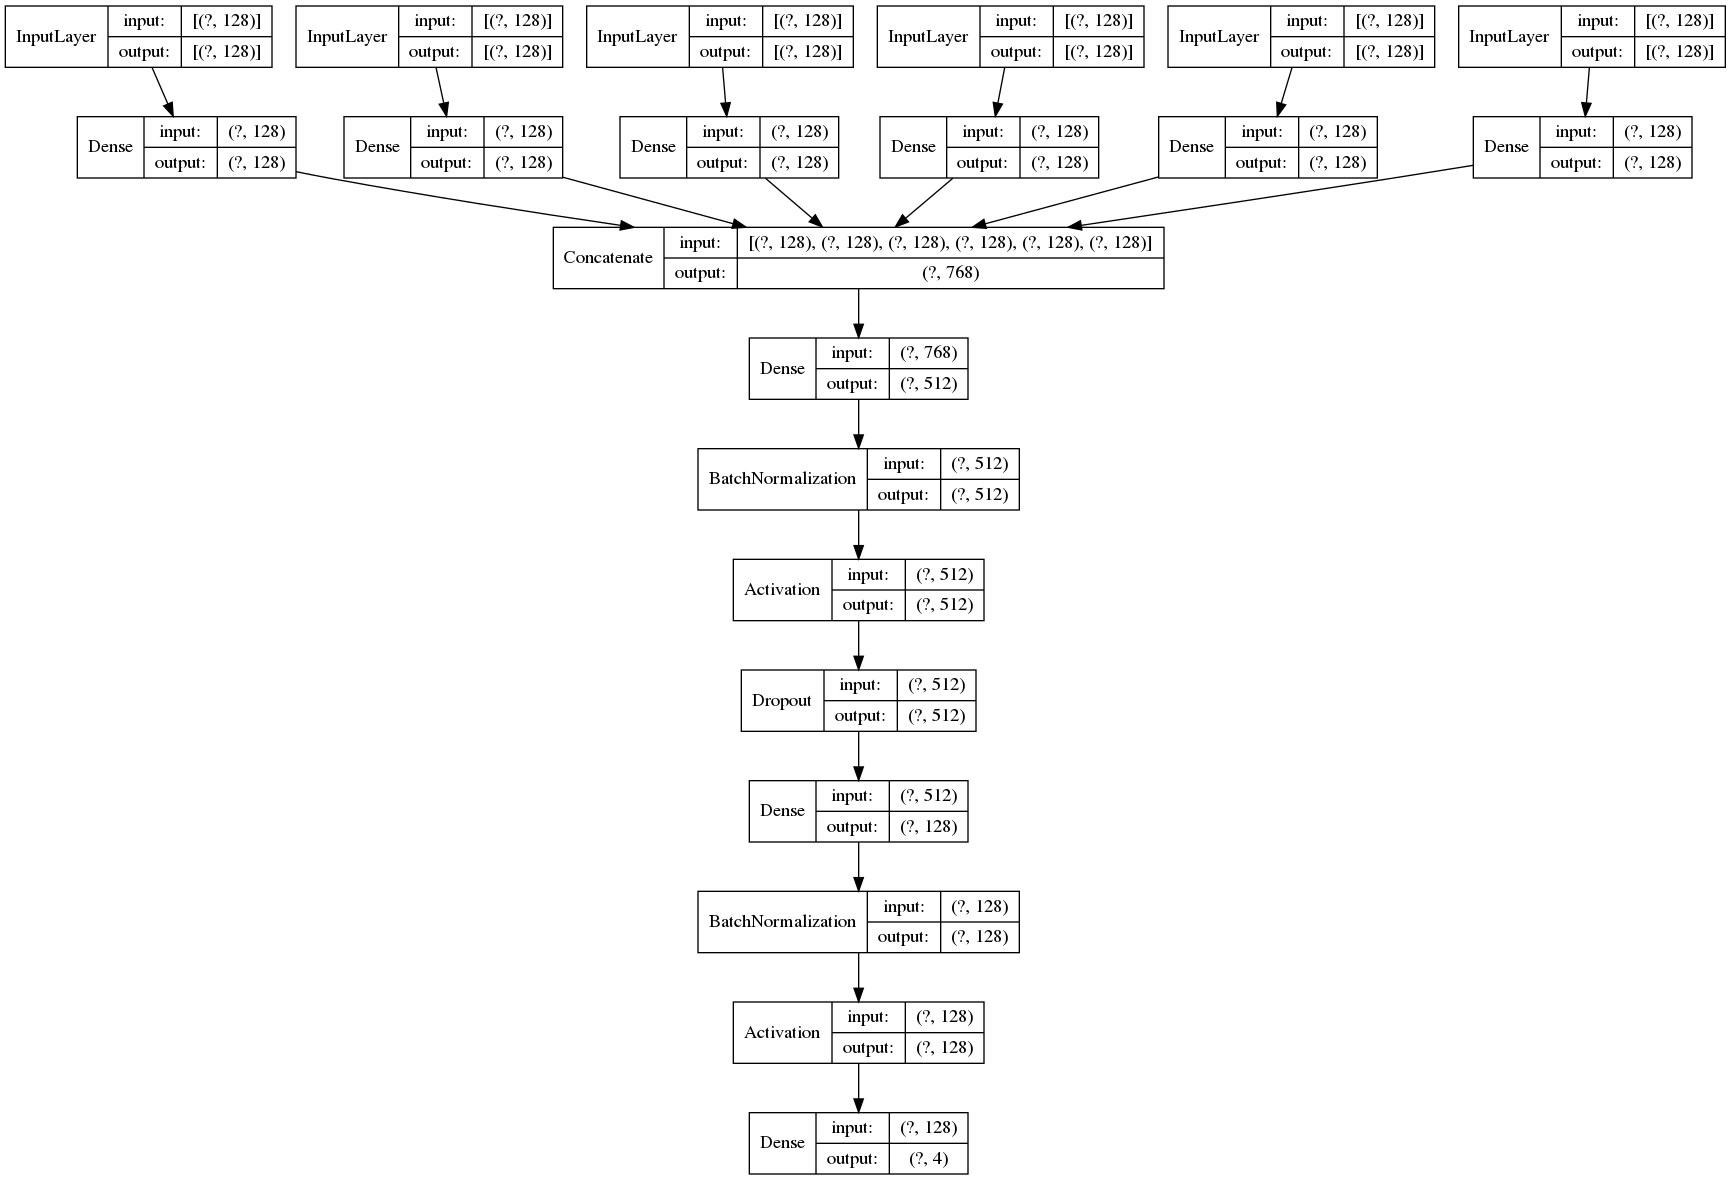

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

### 学習

In [ ]:
#DATA = data()
#x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly, normal_path_test, anomaly_path_test = DATA.get_data()

#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1

anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

x = np.vstack((x_train_normal, x_ref))
x1 = model_1_1.predict(x)
x2 = model_2_1.predict(x)
x3 = model_3_1.predict(x)
x4 = model_4_1.predict(x)
x5 = model_5_1.predict(x)
x6 = model_6_1.predict(x)

y = np.vstack((normal_label, y_ref))
classes =  y_ref.shape[1]


print("training...")


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, amsgrad=True),
              metrics=['accuracy'])

es_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='auto')
hist = model.fit([x1, x2, x3, x4, x5, x6], y, batch_size=batch_size, epochs=epochs, verbose = 1, callbacks=[es_cb], validation_split=0.1)

model.save_weights(model_naming)

ArcFace training...
Epoch 1/15
333/333 [==============================] - 2s 5ms/step - loss: 1.4603 - accuracy: 0.3303 - val_loss: 1.5421 - val_accuracy: 0.3784
Epoch 2/15
333/333 [==============================] - 1s 4ms/step - loss: 1.3355 - accuracy: 0.4033 - val_loss: 1.5857 - val_accuracy: 0.3041
Epoch 3/15
333/333 [==============================] - 1s 4ms/step - loss: 1.2857 - accuracy: 0.4394 - val_loss: 1.7148 - val_accuracy: 0.1014
Epoch 4/15
333/333 [==============================] - 1s 4ms/step - loss: 1.2429 - accuracy: 0.4612 - val_loss: 1.6950 - val_accuracy: 0.0405
Epoch 5/15
333/333 [==============================] - 2s 5ms/step - loss: 1.2443 - accuracy: 0.4628 - val_loss: 1.6865 - val_accuracy: 0.0743
Epoch 6/15
333/333 [==============================] - 1s 4ms/step - loss: 1.2059 - accuracy: 0.4793 - val_loss: 1.7164 - val_accuracy: 0.0405
Epoch 7/15
333/333 [==============================] - 2s 5ms/step - loss: 1.1988 - accuracy: 0.4733 - val_loss: 1.7257 - val_acc

In [ ]:
#saveフォルダ
if not os.path.exists(save_path):
  os.makedirs(save_path)

if not os.path.exists(save_path + "/weights"):
  os.makedirs(save_path + "/weights")

model.save_weights(str(save_path + "/weights/" + model_naming))


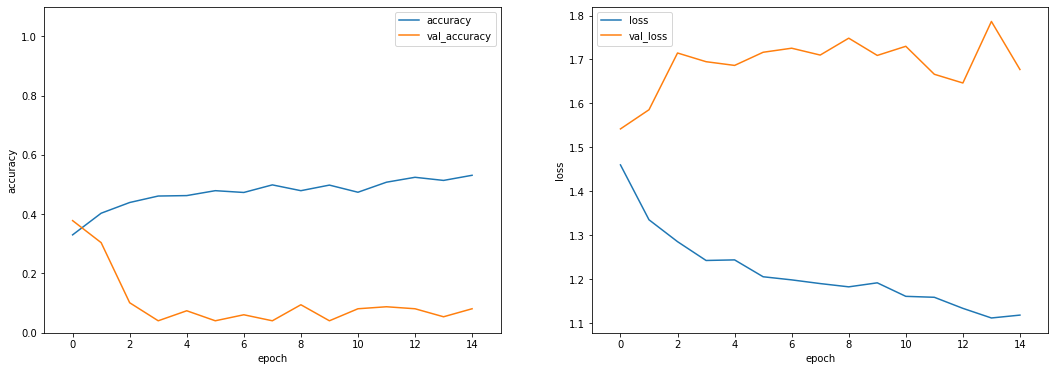

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 3, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 

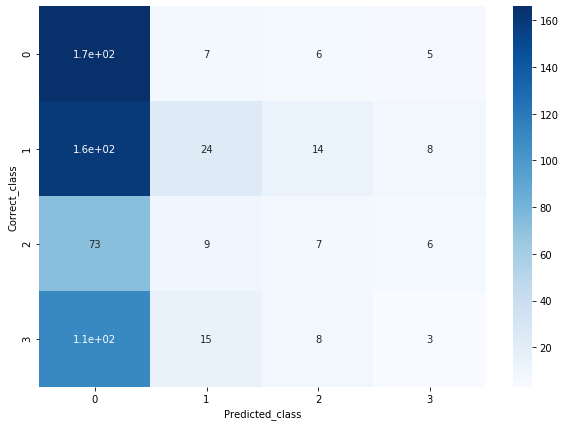

In [ ]:
x_test =np.vstack((x_test_normal, x_test_anomaly))

#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1
anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

y_test = np.vstack((normal_label, y_ref))



###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
#scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
#print("")


### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()





import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()

x1_in = model_1_1.predict(x_test)
x2_in = model_2_1.predict(x_test)
x3_in = model_3_1.predict(x_test)
x4_in = model_4_1.predict(x_test)
x5_in = model_5_1.predict(x_test)
x6_in = model_6_1.predict(x_test)


predicted_class = []
prediction_y = model.predict([x1_in, x2_in, x3_in, x4_in, x5_in, x6_in])

for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2] and prediction_y[i][0] >= prediction_y[i][3]:
    predicted_class.append(0)
  elif prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2] and prediction_y[i][1] >= prediction_y[i][3]:
    predicted_class.append(1)
  elif prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1] and prediction_y[i][2] >= prediction_y[i][3]:
    predicted_class.append(2)
  elif prediction_y[i][3] >= prediction_y[i][0] and prediction_y[i][3] >= prediction_y[i][1] and prediction_y[i][3] >= prediction_y[i][2]:
    predicted_class.append(3)
  else:
    print("error")
print(predicted_class)

testing_path = "/media/deepstation/Transcend/data/data_2/train_1/testing/"
n_num = glob.glob(testing_path + 'Normal/*.png')
a_num = glob.glob(testing_path + 'Atypical/*.png')
d_num = glob.glob(testing_path + 'Dysplasia/*.png')
c_num = glob.glob(testing_path + 'CIS/*.png')
label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
for i in range(len(d_num)):
  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(3)
print(label_class)

print_cmx(label_class, predicted_class)

## 統合モデル②

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import time
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet import *
#******************************************************************************
#クラスの数、クラスの名前
num_classes = 4
folder = ["Normal","Atypical","Dysplasia","CIS"]

#学習画像のサイズ                                     
model_number = 4

#エポック、バッチサイズ
epochs = 15
batch_size = 4
save_timing = 5

#使用する学習セット
data_num = 2

train_set_num = 1
base_set_num = 2

#validationの合計数
#val_num = 160

#学習ナンバー
learnig_num = 200
day = 20201222

#******************************************************************************

#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(train_set_num)
print(data_path)
#モデルの名前
model_naming = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num)+".h5"
print(model_naming)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#CVSの名前
cvs_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".cvs"
print(cvs_name)

#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
base_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(base_set_num) 
validation_path = data_path+ "/validation/"
testing_path = data_path + "/testing/"




/media/deepstation/Transcend/data/data_2/train_1
learning_200_data_2_train_set_1.h5
learning_200_data_2_train_set_1.json
learning_200_data_2_train_set_1.cvs
/media/deepstation/Transcend/save/learning_200_data_2_train_set_1_20201222


In [ ]:
from keras.backend import sigmoid
from random import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
import numpy as np

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
# 入力を定義
input1 = Input(shape=(2,))
input2 = Input(shape=(2,))
input3 = Input(shape=(2,))
input4 = Input(shape=(2,))
input5 = Input(shape=(2,))
input6 = Input(shape=(2,))

# 入力1から結合前まで
x1 = Dense(2, activation="linear")(input1)
x1 = Model(inputs=input1, outputs=x1)

# 入力2から結合前まで
x2 = Dense(2, activation="linear")(input2)
x2 = Model(inputs=input2, outputs=x2)

# 入力2から結合前まで
x3 = Dense(2, activation="linear")(input3)
x3 = Model(inputs=input3, outputs=x3)

# 入力1から結合前まで
x4 = Dense(2, activation="linear")(input4)
x4 = Model(inputs=input4, outputs=x4)

# 入力2から結合前まで
x5 = Dense(2, activation="linear")(input5)
x5 = Model(inputs=input5, outputs=x5)

# 入力2から結合前まで
x6 = Dense(2, activation="linear")(input6)
x6 = Model(inputs=input6, outputs=x6)

# 結合
combined = concatenate([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output])

# 密結合
x = Dense(24)(combined)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

predictions = Dense(4, activation="softmax")(x)
model = Model(inputs = [x1.input, x2.input, x3.input, x4.input, x5.input, x6.input], outputs = predictions)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 2)]          0                                            
______________________________________________________________________________________

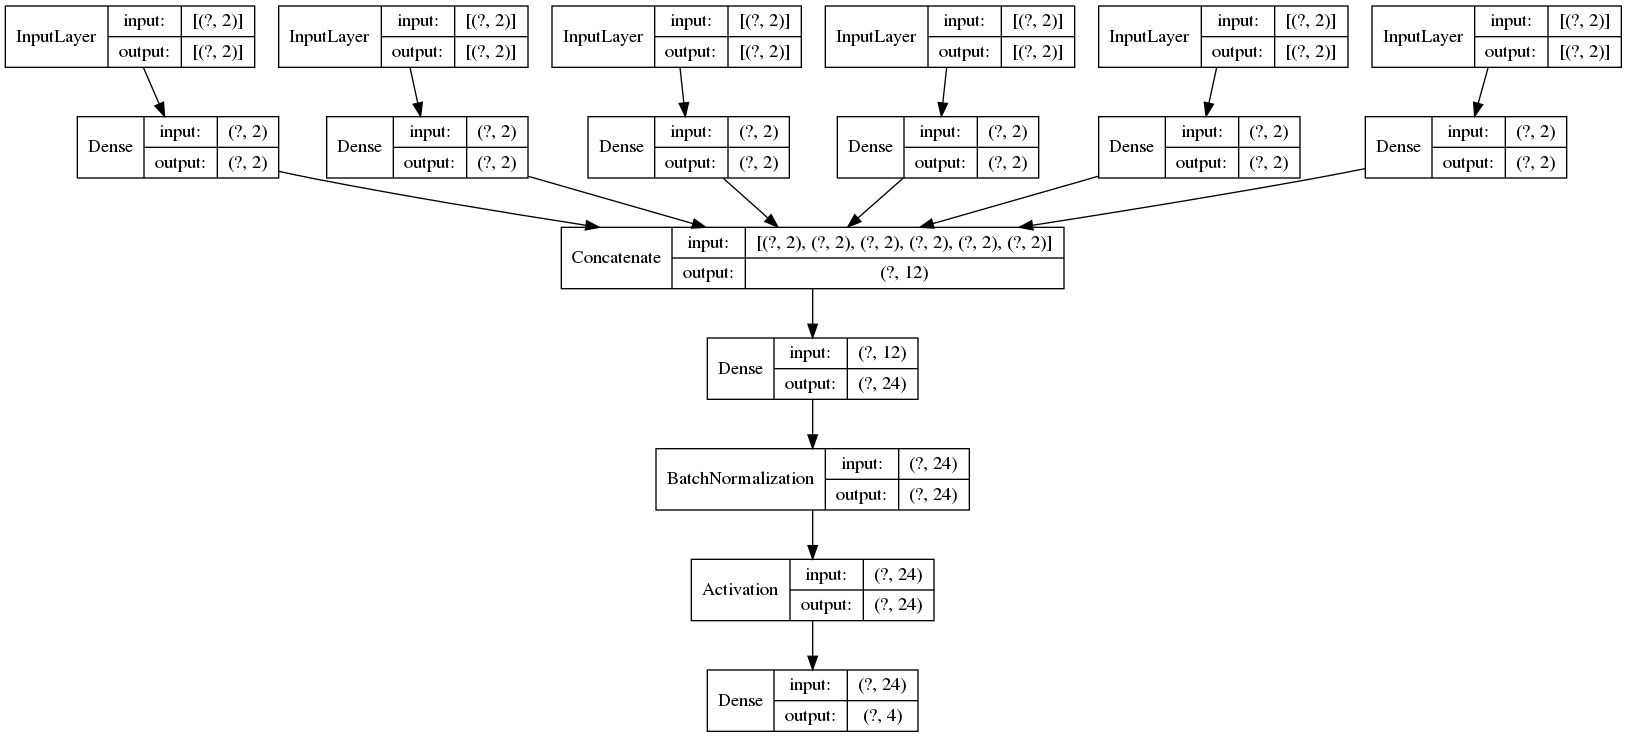

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

### 学習

In [ ]:
#DATA = data()
#x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly, normal_path_test, anomaly_path_test = DATA.get_data()

#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1

anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

x = np.vstack((x_train_normal, x_ref))
x1 = model_1_2.predict(x)
x2 = model_2_2.predict(x)
x3 = model_3_2.predict(x)
x4 = model_4_2.predict(x)
x5 = model_5_2.predict(x)
x6 = model_6_2.predict(x)

y = np.vstack((normal_label, y_ref))
classes =  y_ref.shape[1]


print("training...")


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, amsgrad=True),
              metrics=['accuracy'])

es_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='auto')
hist = model.fit([x1, x2, x3, x4, x5, x6], y, batch_size=batch_size, epochs=epochs, verbose = 1, callbacks=[es_cb], validation_split=0.1)

model.save_weights(model_naming)

training...
Epoch 1/15
333/333 [==============================] - 1s 2ms/step - loss: 1.6166 - accuracy: 0.2137 - val_loss: 1.3870 - val_accuracy: 0.4054
Epoch 2/15
333/333 [==============================] - 0s 1ms/step - loss: 1.5273 - accuracy: 0.2287 - val_loss: 1.4685 - val_accuracy: 0.4054
Epoch 3/15
333/333 [==============================] - 0s 1ms/step - loss: 1.4603 - accuracy: 0.2588 - val_loss: 1.4891 - val_accuracy: 0.3649
Epoch 4/15
333/333 [==============================] - 0s 1ms/step - loss: 1.4300 - accuracy: 0.2709 - val_loss: 1.5074 - val_accuracy: 0.2770
Epoch 5/15
333/333 [==============================] - 0s 1ms/step - loss: 1.3886 - accuracy: 0.3145 - val_loss: 1.5766 - val_accuracy: 0.1419
Epoch 6/15
333/333 [==============================] - 1s 2ms/step - loss: 1.3492 - accuracy: 0.3439 - val_loss: 1.6003 - val_accuracy: 0.1149
Epoch 7/15
333/333 [==============================] - 0s 1ms/step - loss: 1.3438 - accuracy: 0.3717 - val_loss: 1.6326 - val_accuracy: 0

In [ ]:
#saveフォルダ
if not os.path.exists(save_path):
  os.makedirs(save_path)

if not os.path.exists(save_path + "/weights"):
  os.makedirs(save_path + "/weights")

model.save_weights(str(save_path + "/weights/" + model_naming))


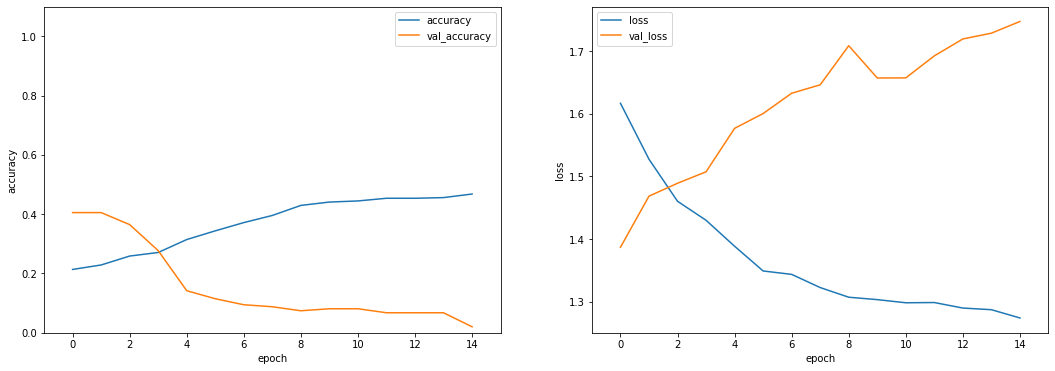

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

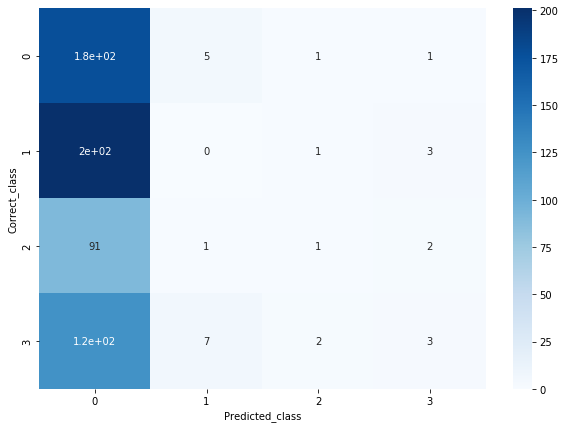

In [ ]:
x_test =np.vstack((x_test_normal, x_test_anomaly))

#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1
anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

y_test = np.vstack((normal_label, y_ref))



###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
#scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
#print("")


### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()





import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()

x1_in = model_1_2.predict(x_test)
x2_in = model_2_2.predict(x_test)
x3_in = model_3_2.predict(x_test)
x4_in = model_4_2.predict(x_test)
x5_in = model_5_2.predict(x_test)
x6_in = model_6_2.predict(x_test)


predicted_class = []
prediction_y = model.predict([x1_in, x2_in, x3_in, x4_in, x5_in, x6_in])

for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2] and prediction_y[i][0] >= prediction_y[i][3]:
    predicted_class.append(0)
  elif prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2] and prediction_y[i][1] >= prediction_y[i][3]:
    predicted_class.append(1)
  elif prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1] and prediction_y[i][2] >= prediction_y[i][3]:
    predicted_class.append(2)
  elif prediction_y[i][3] >= prediction_y[i][0] and prediction_y[i][3] >= prediction_y[i][1] and prediction_y[i][3] >= prediction_y[i][2]:
    predicted_class.append(3)
  else:
    print("error")
print(predicted_class)

testing_path = "/media/deepstation/Transcend/data/data_2/train_1/testing/"
n_num = glob.glob(testing_path + 'Normal/*.png')
a_num = glob.glob(testing_path + 'Atypical/*.png')
d_num = glob.glob(testing_path + 'Dysplasia/*.png')
c_num = glob.glob(testing_path + 'CIS/*.png')
label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
for i in range(len(d_num)):
  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(3)
print(label_class)

print_cmx(label_class, predicted_class)

## 統合モデル②

In [2]:
%cd /media/deepstation/Transcend/learning/UC/model_metric_learning/Imbalanced_Image_Anomaly_Detection

/media/deepstation/Transcend/learning/UC/model_metric_learning/Imbalanced_Image_Anomaly_Detection


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from PIL import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import time
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from efficientnet import *
#******************************************************************************
#クラスの数、クラスの名前
num_classes = 4
folder = ["Normal","Atypical","Dysplasia","CIS"]

#学習画像のサイズ                                     
model_number = 4

#エポック、バッチサイズ
epochs = 20
batch_size = 4
save_timing = 5

#使用する学習セット
data_num = 2

train_set_num = 18
#base_set_num = 2

#validationの合計数
#val_num = 160

#学習ナンバー
learnig_num = 400
day = 20201222

#******************************************************************************

#学習データのディレクトリ
data_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(train_set_num)
print(data_path)
#モデルの名前
model_naming = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_epoch_" + str(epochs) + "_batch_" + str(batch_size) +".h5"
print(model_naming)
#.jsonの名前
json_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".json"
print(json_name)
#CVSの名前
cvs_name = "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + ".cvs"
print(cvs_name)

#一時保存先のpath
save_path = "/media/deepstation/Transcend/save/" + "learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) + "_" + str(day)
print(save_path)

training_path = data_path + "/training/"
#base_path = "/media/deepstation/Transcend/data/data_"+ str(data_num) + "/train_" + str(base_set_num) 
validation_path = data_path+ "/validation/"
testing_path = data_path + "/testing/"




/media/deepstation/Transcend/data/data_2/train_18
learning_400_data_2_train_set_18_epoch_20_batch_4.h5
learning_400_data_2_train_set_18.json
learning_400_data_2_train_set_18.cvs
/media/deepstation/Transcend/save/learning_400_data_2_train_set_18_20201222


In [ ]:
class data:
    def resize(self, x, to_color=False):
        result = []

        for i in range(len(x)):
            if to_color:
                img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
                img = cv2.resize(img,dsize=(image_size,image_size))
            else:
                img = cv2.resize(x[i],dsize=(image_size,image_size))
            result.append(img)

        return np.array(result)

    def choose_data(self, x, y, ok_label, normal_id, anomaly_id):
        x_normal, x_anomaly = [], []
        x_ref, y_ref = [], []
        j = 0
        for i in range(len(y)):
            if y[i] == normal_id:
                x_normal.append(x[i].reshape((x.shape[1:])))
            elif y[i] == 1 or y[i] ==2 or y[i] == 3 :
                x_anomaly.append(x[i].reshape((x.shape[1:])))
                #if j < len(ok_label):
                x_ref.append(x[i].reshape((x.shape[1:])))
                y_ref.append(y[i])
                #j += 1


        return np.array(x_normal), np.array(x_anomaly), np.array(x_ref), y_ref
    
    def get_data_A(self):
      img = glob.glob(training_path + "/Atypical" + "/*.png")
      img_data = np.zeros((len(img),image_size,image_size,3),dtype=np.float32)
      for i in range(len(img)):
        image = read_and_preprocess_img(img[i],size=(image_size,image_size))
        img_data[i] = image
      img_data = self.resize(img_data)
      return img_data

    def get_data_C(self):
      img = glob.glob(training_path + "/CIS"  + '/*.png')
      img_data = np.zeros((len(img),image_size,image_size,3),dtype=np.float32)
      for i in range(len(img)):
        image = read_and_preprocess_img(img[i],size=(image_size,image_size))
        img_data[i] = image
      img_data = self.resize(img_data)
      return img_data

    def get_data(self):
        #-----------------------------------------------------------------------
        

        oks = glob.glob(data_path + '/training/Normal/*.png')
        ngs = glob.glob(data_path + '/training/Atypical/*.png') + glob.glob(data_path + '/training/Dysplasia/*.png') + glob.glob(data_path + '/training/CIS/*.png')
        
        ok_data = np.zeros((len(oks),image_size,image_size,3),dtype=np.float32)
        ok_label = np.zeros(len(oks))
        
        ng_data = np.zeros((len(ngs),image_size,image_size,3),dtype=np.float32)
        ng_label = np.zeros(len(ngs))
        
        normal_path = []
        anomaly_path = []

        for i in range(len(oks)):
           print(i+1,'/',len(oks))
           image = read_and_preprocess_img(oks[i],size=(image_size,image_size))
           ok_data[i] = image
           ok_label[i] = 0
           normal_path.append(oks[i])

        
        ng_folder = ["Atypical","Dysplasia","CIS"]
        j = 0
        for index, name in enumerate(ng_folder):
          dir = training_path + name
          files = glob.glob(dir + "/*.png")    
          for i, file in enumerate(files): 
            ng_label[j] = index + 1
            j += 1
        
        for i in range(len(ngs)):
           print(i+1,'/',len(ngs))
           image = read_and_preprocess_img(ngs[i],size=(image_size,image_size))
           ng_data[i] = image
           anomaly_path.append(ngs[i])
        
        ok_data_train = ok_data
        ng_data_train = ng_data
        ok_label_train = ok_label
        ng_label_train = ng_label

        #-----------------------------------------------------------------------
        oks = glob.glob(data_path + '/testing/Normal/*.png')
        ngs = glob.glob(data_path + '/testing/Atypical/*.png') + glob.glob(data_path + '/testing/Dysplasia/*.png') + glob.glob(data_path + '/testing/CIS/*.png') 
        ok_data = np.zeros((len(oks),image_size,image_size,3),dtype=np.float32)
        ok_label = np.zeros(len(oks))
        ng_data = np.zeros((len(ngs),image_size,image_size,3),dtype=np.float32)
        ng_label = np.zeros(len(ngs))
        normal_path = []
        anomaly_path = []

        for i in range(len(oks)):
           print(i+1,'/',len(oks))
           image = read_and_preprocess_img(oks[i],size=(image_size,image_size))
           ok_data[i] = image
           ok_label[i] = 0
           normal_path.append(oks[i])
        for i in range(len(ngs)):
           print(i+1,'/',len(ngs))
           image = read_and_preprocess_img(ngs[i],size=(image_size,image_size))
           ng_data[i] = image
           ng_label[i] = 1
           anomaly_path.append(ngs[i])


        ok_data_test = ok_data
        ng_data_test = ng_data
        normal_path_test = normal_path
        anomaly_path_test = anomaly_path
        ok_label_test = ok_label
        ng_label_test = ng_label

        #--------------------------------------------------------------------





        
        x_train = np.concatenate((ok_data_train, ng_data_train),axis=0)
        x_test = np.concatenate((ok_data_test, ng_data_test),axis=0)

        y_train = np.concatenate((ok_label_train, ng_label_train),axis=0)
        y_test = np.concatenate((ok_label_test, ng_label_test),axis=0)
        

        x_train_normal, _, x_ref, y_ref = self.choose_data(x_train, y_train, ok_label_train, 0, 1)

        y_ref = to_categorical(y_ref, num_classes=4)

        x_test_normal, x_test_anomaly, _, _ = self.choose_data(x_test, y_test, ok_label_test, 0, 1)

        x_train_normal = self.resize(x_train_normal)
        x_ref = self.resize(x_ref)
        x_test_normal = self.resize(x_test_normal)
        x_test_anomaly = self.resize(x_test_anomaly)

        return x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly, normal_path_test, anomaly_path_test


class Arcfacelayer(Layer):
    def __init__(self, output_dim, s=30, m=0.50, easy_margin=False):
        self.output_dim = output_dim
        self.s = s
        self.m = m
        self.easy_margin = easy_margin
        super(Arcfacelayer, self).__init__()

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[0][1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Arcfacelayer, self).build(input_shape)
 
    def call(self, x):
        y = x[1]
        x_normalize = tf.math.l2_normalize(x[0])
        k_normalize = tf.math.l2_normalize(self.kernel)

        cos_m = K.cos(self.m)
        sin_m = K.sin(self.m)
        th = K.cos(np.pi - self.m)
        mm = K.sin(np.pi - self.m) * self.m

        cosine = K.dot(x_normalize, k_normalize)
        sine = K.sqrt(1.0 - K.square(cosine))

        phi = cosine * cos_m - sine * sin_m

        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine) 

        else:
            phi = tf.where(cosine > th, phi, cosine - mm) 

        output = (y * phi) + ((1.0 - y) * cosine) 
        output *= self.s

        return output

    def compute_output_shape(self, input_shape):

        return (input_shape[0][0], self.output_dim)



def no_train_arcface(x, y, classes):
    print("ArcFace training...")
    base_model=MobileNetV2(input_shape=x.shape[1:],alpha=0.5,
                           weights='imagenet',
                           include_top=False)

    c = base_model.output
    yinput = Input(shape=(classes,))
    hidden = GlobalAveragePooling2D()(c) 
    c = Arcfacelayer(classes, 30, 0.05)([hidden,yinput])
    prediction = Activation('softmax')(c)
    model = Model(inputs=[base_model.input, yinput], outputs=prediction)

#    model.compile(loss='categorical_crossentropy',
#                  optimizer=Adam(lr=0.0001, amsgrad=True),
#                  metrics=['accuracy'])

#    es_cb = keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=0, mode='auto')

#    hist = model.fit([x, y], y, batch_size=4, epochs=epochs, verbose = 1, callbacks=[es_cb])

    return model

def get_score_arc(model, train, test):
    model = Model(model.get_layer(index=0).input, model.get_layer(index=-4).output)
    hold_vector = model.predict(train)
    predict_vector = model.predict(test)

    score = []

    for i in range(len(predict_vector)):
        cos_similarity = cosine_similarity(predict_vector[i], hold_vector)
        score.append(np.max(cos_similarity))
    return np.array(score)

def get_score_arc_2(model, train, test):
    model = Model(model.get_layer(index=0).input, model.get_layer(index=-4).output)
    hold_vector = model.predict(train)
    print(hold_vector)
    hold_vector = np.mean(hold_vector, axis=0)
    print("average")
    print(hold_vector)
    predict_vector = model.predict(test)

    score = []

    for i in range(len(predict_vector)):
        cos_similarity = cosine_similarity(predict_vector[i], hold_vector)
        score.append(np.max(cos_similarity))
    return np.array(score)

def cosine_similarity(x1, x2): 
    if x1.ndim == 1:
        x1 = x1[np.newaxis]
    if x2.ndim == 1:
        x2 = x2[np.newaxis]
    x1_norm = np.linalg.norm(x1, axis=1)
    x2_norm = np.linalg.norm(x2, axis=1)
    cosine_sim = np.dot(x1, x2.T)/(x1_norm*x2_norm+1e-10)
    return cosine_sim

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 0, keepdims = True)
    return f

def ScoreCam(model, hold_vector, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict([img_array,hold_vector]))
    act_map_array = Model(inputs=model.inputs, outputs=model.get_layer(index=layer_name).output).predict([img_array,hold_vector])

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], (input_shape[0],input_shape[1]), interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    hold_vector2 = np.zeros((masked_input_array.shape[0], 2))
    hold_vector2[:,1] = 1
    pred_from_masked_input_array = softmax(model.predict([masked_input_array, hold_vector2]))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam = cam - np.min(cam)
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
 
    return superimposed_img

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def read_and_preprocess_img(path, size=(image_size,image_size)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
from keras.backend import sigmoid
from random import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
import numpy as np

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

#base_model = model_name(weights='noisy-student',input_shape=x.shape[1:], include_top=False)
if model_number == 0:
    model = enet.EfficientNetB0(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 1:
    model = enet.EfficientNetB1(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 2:
    model = enet.EfficientNetB2(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 3:
    model = enet.EfficientNetB3(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 4:
    model = enet.EfficientNetB4(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 5:
    model = enet.EfficientNetB5(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 6:
    model = enet.EfficientNetB6(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
elif model_number == 7:
    model = enet.EfficientNetB7(include_top=False, input_shape=(image_size,image_size,3), pooling='avg', weights='imagenet')
else:
    print('set model_number 0 to 7')

In [ ]:
x1 = model_1_1.output
x2 = model_2_1.output
x3 = model_3_1.output
x4 = model_4_1.output
x5 = model_5_1.output
x6 = model_6_1.output

combined = concatenate([x1, x2, x3, x4, x5, x6])


# 密結合
x = Dense(512)(combined)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)


# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs = [model_1_1.input, model_2_1.input,model_3_1.input,model_4_1.input,model_5_1.input,model_6_1.input], outputs = predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

ストリーミング出力は最後の 5000 行に切り捨てられました。
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 1, 1, 8)      1544        lambda_38[0][0]                  
__________________________________________________________________________________________________
conv2d_280 (Conv2D)             (None, 1, 1, 8)      1544        lambda_70[0][0]                  
__________________________________________________________________________________________________
conv2d_408 (Conv2D)             (None, 1, 1, 8)      1544        lambda_102[0][0]                 
__________________________________________________________________________________________________
conv2d_536 (Conv2D)             (None, 1, 1, 8)      1544        lambda_134[0][0]                 
__________________________________________________________________________________________________
conv2d_664 (Conv2D)             (None, 1, 1, 8)      1544        lambda_166[0

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
DATA = data()
x_train_normal, x_ref, y_ref, x_test_normal, x_test_anomaly, normal_path_test, anomaly_path_test = DATA.get_data()

1 / 257
2 / 257
3 / 257
4 / 257
5 / 257
6 / 257
7 / 257
8 / 257
9 / 257
10 / 257
11 / 257
12 / 257
13 / 257
14 / 257
15 / 257
16 / 257
17 / 257
18 / 257
19 / 257
20 / 257
21 / 257
22 / 257
23 / 257
24 / 257
25 / 257
26 / 257
27 / 257
28 / 257
29 / 257
30 / 257
31 / 257
32 / 257
33 / 257
34 / 257
35 / 257
36 / 257
37 / 257
38 / 257
39 / 257
40 / 257
41 / 257
42 / 257
43 / 257
44 / 257
45 / 257
46 / 257
47 / 257
48 / 257
49 / 257
50 / 257
51 / 257
52 / 257
53 / 257
54 / 257
55 / 257
56 / 257
57 / 257
58 / 257
59 / 257
60 / 257
61 / 257
62 / 257
63 / 257
64 / 257
65 / 257
66 / 257
67 / 257
68 / 257
69 / 257
70 / 257
71 / 257
72 / 257
73 / 257
74 / 257
75 / 257
76 / 257
77 / 257
78 / 257
79 / 257
80 / 257
81 / 257
82 / 257
83 / 257
84 / 257
85 / 257
86 / 257
87 / 257
88 / 257
89 / 257
90 / 257
91 / 257
92 / 257
93 / 257
94 / 257
95 / 257
96 / 257
97 / 257
98 / 257
99 / 257
100 / 257
101 / 257
102 / 257
103 / 257
104 / 257
105 / 257
106 / 257
107 / 257
108 / 257
109 / 257
110 / 257
111 / 25

In [ ]:
x_val = []
y_val = []

#学習データのディレクトリ
folder_real = ["Normal","Atypical","Dysplasia","CIS"]

for index, name in enumerate(folder_real):
    dir = validation_path + name
    files = glob.glob(dir + "/*.png")    
    for i, file in enumerate(files):    
        image = Image.open(file)                       
        image = image.convert("RGB")    
        image = image.resize((image_size, image_size))
        data = np.asarray(image)        
        x_val.append(data)  
        y_val.append(index)
        print("validation_" + str(name) + ":　"+ str(i)) 
x_val = np.array(x_val)
y_val = np.array(y_val)
x_val = x_val.astype('float32')
x_val /= 255
# ｙ　ラベルをワンホット表現に
y_val = keras.utils.to_categorical(y_val, num_classes)
print(x_val.shape[0], 'validation samples')

validation_Normal:　0
validation_Normal:　1
validation_Normal:　2
validation_Normal:　3
validation_Normal:　4
validation_Normal:　5
validation_Normal:　6
validation_Normal:　7
validation_Normal:　8
validation_Normal:　9
validation_Normal:　10
validation_Normal:　11
validation_Normal:　12
validation_Normal:　13
validation_Normal:　14
validation_Normal:　15
validation_Normal:　16
validation_Normal:　17
validation_Normal:　18
validation_Normal:　19
validation_Normal:　20
validation_Normal:　21
validation_Normal:　22
validation_Normal:　23
validation_Normal:　24
validation_Normal:　25
validation_Normal:　26
validation_Normal:　27
validation_Normal:　28
validation_Normal:　29
validation_Normal:　30
validation_Normal:　31
validation_Normal:　32
validation_Normal:　33
validation_Normal:　34
validation_Normal:　35
validation_Normal:　36
validation_Normal:　37
validation_Normal:　38
validation_Normal:　39
validation_Normal:　40
validation_Normal:　41
validation_Normal:　42
validation_Normal:　43
validation_Normal:　44
validation_Normal:　4

### 学習

In [ ]:


#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1

anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

x = np.vstack((x_train_normal, x_ref))

y = np.vstack((normal_label, y_ref))
classes =  y_ref.shape[1]


print("training...")


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, amsgrad=True),
              metrics=['accuracy'])

# checkpointの設定
checkpoint = ModelCheckpoint(
                    filepath="learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_" + str(train_set_num) +  "_batch_" + str(batch_size) + "_{epoch:02d}.h5",
                    monitor='val_loss',
                    save_best_only=False,
                    period=1,
                )

es_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='auto')

hist = model.fit([x, x, x, x, x, x], y, batch_size=batch_size, epochs=epochs, verbose = 1, callbacks=[es_cb, checkpoint], validation_data=([x_val,x_val,x_val,x_val,x_val,x_val], y_val))
#hist = model.fit([x, x, x, x, x, x], y, batch_size=batch_size, epochs=epochs, verbose = 1, callbacks=[es_cb, checkpoint])
#hist = model.fit([x, x, x, x, x, x], y, batch_size=batch_size, epochs=epochs, verbose = 1, callbacks=[es_cb, checkpoint], validation_split=0.2)
model.save_weights(model_naming)

training...
Epoch 1/20
240/240 [==============================] - 1436s 6s/step - loss: 1.4224 - accuracy: 0.3260 - val_loss: 1.4098 - val_accuracy: 0.3514
Epoch 2/20
240/240 [==============================] - 1409s 6s/step - loss: 1.2149 - accuracy: 0.4556 - val_loss: 1.4472 - val_accuracy: 0.3384
Epoch 3/20
240/240 [==============================] - 1403s 6s/step - loss: 1.1336 - accuracy: 0.5005 - val_loss: 1.5836 - val_accuracy: 0.1714
Epoch 4/20
240/240 [==============================] - 1401s 6s/step - loss: 1.0531 - accuracy: 0.5664 - val_loss: 1.7723 - val_accuracy: 0.1280
Epoch 5/20
240/240 [==============================] - 1406s 6s/step - loss: 0.9842 - accuracy: 0.5977 - val_loss: 1.9630 - val_accuracy: 0.1540
Epoch 6/20
240/240 [==============================] - 1404s 6s/step - loss: 0.9352 - accuracy: 0.6008 - val_loss: 1.8763 - val_accuracy: 0.1562
Epoch 7/20
240/240 [==============================] - 1394s 6s/step - loss: 0.8788 - accuracy: 0.6489 - val_loss: 2.1368 - v

In [ ]:
#saveフォルダ
if not os.path.exists(save_path):
  os.makedirs(save_path)

if not os.path.exists(save_path + "/weights"):
  os.makedirs(save_path + "/weights")

model.save_weights(str(save_path + "/weights/" + model_naming))


In [ ]:
#model.load_weights(save_path + "/weights/" + model_naming)
#---------------------------------------------------------------------------
model.load_weights("learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_16"  +  "_batch_" + str(batch_size) + "_12.h5")
#---------------------------------------------------------------------------

model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from sklearn.metrics import accuracy_score


n_num = glob.glob(validation_path + 'Normal/*.png')
a_num = glob.glob(validation_path + 'Atypical/*.png')
d_num = glob.glob(validation_path + 'Dysplasia/*.png')
c_num = glob.glob(validation_path + 'CIS/*.png')


oks_test = glob.glob(data_path + '/validation/Normal/*.png')
ng_1_test = glob.glob(data_path + '/validation/Atypical/*.png')
ng_2_test = glob.glob(data_path + '/validation/Dysplasia/*.png')
ng_3_test = glob.glob(data_path + '/validation/CIS/*.png')

oks_test_data = np.zeros((len(oks_test),image_size,image_size,3),dtype=np.float32)
ng_1_test_data = np.zeros((len(ng_1_test),image_size,image_size,3),dtype=np.float32)
ng_2_test_data = np.zeros((len(ng_2_test),image_size,image_size,3),dtype=np.float32)
ng_3_test_data = np.zeros((len(ng_3_test),image_size,image_size,3),dtype=np.float32)
        
path_img = []
oks_test_path = []
ng_1_test_path = []
ng_2_test_path = []
ng_3_test_path = []

for i in range(len(oks_test)):
  print(i+1,'/',len(oks_test))
  path_img.append(oks_test[i])
  image = read_and_preprocess_img(oks_test[i],size=(image_size,image_size))
  oks_test_data[i] = image
  oks_test_path.append(oks_test[i])

for i in range(len(ng_1_test)):
  print(i+1,'/',len(ng_1_test))
  path_img.append(ng_1_test[i])
  image = read_and_preprocess_img(ng_1_test[i],size=(image_size,image_size))
  ng_1_test_data[i] = image
  ng_1_test_path.append(ng_1_test[i])

for i in range(len(ng_2_test)):
  print(i+1,'/',len(ng_2_test))
  path_img.append(ng_2_test[i])
  image = read_and_preprocess_img(ng_2_test[i],size=(image_size,image_size))
  ng_2_test_data[i] = image
  ng_2_test_path.append(ng_2_test[i])

for i in range(len(ng_3_test)):
  print(i+1,'/',len(ng_3_test))
  path_img.append(ng_3_test[i])
  image = read_and_preprocess_img(ng_3_test[i],size=(image_size,image_size))
  ng_3_test_data[i] = image
  ng_3_test_path.append(ng_3_test[i])

oks_test_data = res(oks_test_data)
ng_1_test_data = res(ng_1_test_data)
ng_2_test_data = res(ng_2_test_data)
ng_3_test_data = res(ng_3_test_data)
#-------------------------------------------------------------------------------

x_val = np.vstack((oks_test_data, ng_1_test_data, ng_2_test_data, ng_3_test_data))



label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
for i in range(len(d_num)):
  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(3)

for i in range(1,21):
  if i < 10:
    model.load_weights("learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_16" +"_batch_" + str(batch_size) + "_0" + str(i) + ".h5")
  else:
    model.load_weights("learning_" + str(learnig_num) + "_data_" + str(data_num) + "_train_set_16" +"_batch_" + str(batch_size) + "_" + str(i) + ".h5")
  predicted_class = []
  prediction_y = model.predict([x_val,x_val,x_val,x_val,x_val,x_val])
  for i in range(len(prediction_y)):
    if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2] and prediction_y[i][0] >= prediction_y[i][3]:
      predicted_class.append(0)
    elif prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2] and prediction_y[i][1] >= prediction_y[i][3]:
      predicted_class.append(1)
    elif prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1] and prediction_y[i][2] >= prediction_y[i][3]:
      predicted_class.append(2)
    elif prediction_y[i][3] >= prediction_y[i][0] and prediction_y[i][3] >= prediction_y[i][1] and prediction_y[i][3] >= prediction_y[i][2]:
      predicted_class.append(3)
    else:
      print("error")
  
  print(accuracy_score(label_class, predicted_class))
  


1 / 160
2 / 160
3 / 160
4 / 160
5 / 160
6 / 160
7 / 160
8 / 160
9 / 160
10 / 160
11 / 160
12 / 160
13 / 160
14 / 160
15 / 160
16 / 160
17 / 160
18 / 160
19 / 160
20 / 160
21 / 160
22 / 160
23 / 160
24 / 160
25 / 160
26 / 160
27 / 160
28 / 160
29 / 160
30 / 160
31 / 160
32 / 160
33 / 160
34 / 160
35 / 160
36 / 160
37 / 160
38 / 160
39 / 160
40 / 160
41 / 160
42 / 160
43 / 160
44 / 160
45 / 160
46 / 160
47 / 160
48 / 160
49 / 160
50 / 160
51 / 160
52 / 160
53 / 160
54 / 160
55 / 160
56 / 160
57 / 160
58 / 160
59 / 160
60 / 160
61 / 160
62 / 160
63 / 160
64 / 160
65 / 160
66 / 160
67 / 160
68 / 160
69 / 160
70 / 160
71 / 160
72 / 160
73 / 160
74 / 160
75 / 160
76 / 160
77 / 160
78 / 160
79 / 160
80 / 160
81 / 160
82 / 160
83 / 160
84 / 160
85 / 160
86 / 160
87 / 160
88 / 160
89 / 160
90 / 160
91 / 160
92 / 160
93 / 160
94 / 160
95 / 160
96 / 160
97 / 160
98 / 160
99 / 160
100 / 160
101 / 160
102 / 160
103 / 160
104 / 160
105 / 160
106 / 160
107 / 160
108 / 160
109 / 160
110 / 160
111 / 16

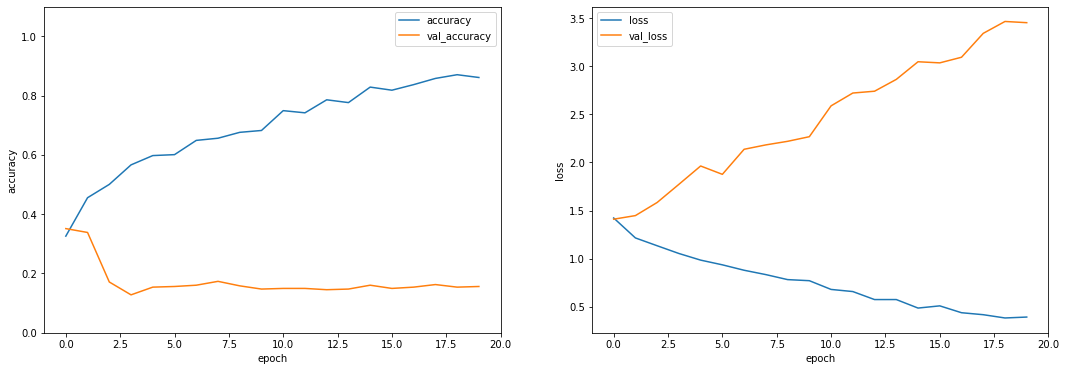

In [ ]:
x_test =np.vstack((x_test_normal, x_test_anomaly))

#ラベルの作成（ワンホット形式）
normal_label = np.zeros((len(x_train_normal), 4))
normal_label[:,0] = 1
anomaly_label = np.zeros((len(x_ref), 4))
#anomaly_label[:,1] = 1
ng_folder = ["Atypical","Dysplasia","CIS"]
count_all = 0
end = 0
for index, name in enumerate(ng_folder):
  dir = training_path + name
  files = glob.glob(dir + "/*.png")    
  for i, file in enumerate(files): 
    anomaly_label[end + i][index+1] = 1
    count_all += 1
  end = count_all

y_test = np.vstack((normal_label, y_ref))



###　Test loss, Test accuracy, AUC, True Positive, True Negative, False Positive, False Negative
#scores = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])
#print("")


### Plot accuracy & loss
plt.figure(figsize = (18,6))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"], label = "accuracy")
plt.plot(hist.history["val_accuracy"], label = "val_accuracy")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(-1, epochs)
plt.ylim(0.0, 1.1)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)

# loss
plt.subplot(1, 2, 2)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
#plt.xticks(np.arange())
#plt.yticks(np.arange())
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(-1, epochs)
#plt.title("")
plt.legend(loc = "best")
#plt.grid(color = 'gray', alpha = 0.2)
plt.show()

## 混合配列　統合

1 / 144
2 / 144
3 / 144
4 / 144
5 / 144
6 / 144
7 / 144
8 / 144
9 / 144
10 / 144
11 / 144
12 / 144
13 / 144
14 / 144
15 / 144
16 / 144
17 / 144
18 / 144
19 / 144
20 / 144
21 / 144
22 / 144
23 / 144
24 / 144
25 / 144
26 / 144
27 / 144
28 / 144
29 / 144
30 / 144
31 / 144
32 / 144
33 / 144
34 / 144
35 / 144
36 / 144
37 / 144
38 / 144
39 / 144
40 / 144
41 / 144
42 / 144
43 / 144
44 / 144
45 / 144
46 / 144
47 / 144
48 / 144
49 / 144
50 / 144
51 / 144
52 / 144
53 / 144
54 / 144
55 / 144
56 / 144
57 / 144
58 / 144
59 / 144
60 / 144
61 / 144
62 / 144
63 / 144
64 / 144
65 / 144
66 / 144
67 / 144
68 / 144
69 / 144
70 / 144
71 / 144
72 / 144
73 / 144
74 / 144
75 / 144
76 / 144
77 / 144
78 / 144
79 / 144
80 / 144
81 / 144
82 / 144
83 / 144
84 / 144
85 / 144
86 / 144
87 / 144
88 / 144
89 / 144
90 / 144
91 / 144
92 / 144
93 / 144
94 / 144
95 / 144
96 / 144
97 / 144
98 / 144
99 / 144
100 / 144
101 / 144
102 / 144
103 / 144
104 / 144
105 / 144
106 / 144
107 / 144
108 / 144
109 / 144
110 / 144
111 / 14

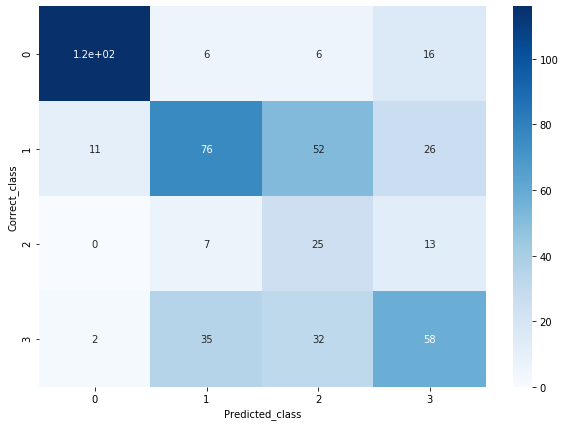

['N2_9_', 'C_219', 'A_226', 'D_213', 'C_226', 'N2_13', 'A_229', 'C_224', 'N2_14', 'D_206', 'N2_15', 'A_228', 'N2_11', 'C_225', 'A_231', 'D_212', 'D_214', 'C_223', 'N2_16', 'C_222', 'N2_10', 'C_220', 'C_221', 'N2_12', 'A_224', 'A_230', 'D_208', 'A_227', 'A_225']
Completed.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def res (x):
  result = []
  for i in range(len(x)):
    img = cv2.resize(x[i],dsize=(image_size,image_size))
    result.append(img)
  return np.array(result)

def get_score(model,hold_vector_1, hold_vector_2,  hold_vector_3,  hold_vector_4, test):
  model = Model(model.get_layer(index=0).input, model.get_layer(index=-4).output)
  predict_vector = model.predict(test)

  score_1 = []
  score_2 = []
  score_3 = []
  score_4 = []

  for i in range(len(predict_vector)):
      cos_similarity = cosine_similarity(predict_vector[i], hold_vector_1)
      score_1.append(np.max(cos_similarity))
  for i in range(len(predict_vector)):
      cos_similarity = cosine_similarity(predict_vector[i], hold_vector_2)
      score_2.append(np.max(cos_similarity))
  for i in range(len(predict_vector)):
      cos_similarity = cosine_similarity(predict_vector[i], hold_vector_3)
      score_3.append(np.max(cos_similarity))
  for i in range(len(predict_vector)):
      cos_similarity = cosine_similarity(predict_vector[i], hold_vector_4)
      score_4.append(np.max(cos_similarity))
   
  return score_1, score_2, score_3, score_4

oks_test = glob.glob(data_path + '/testing/Normal/*.png')
ng_1_test = glob.glob(data_path + '/testing/Atypical/*.png')
ng_2_test = glob.glob(data_path + '/testing/Dysplasia/*.png')
ng_3_test = glob.glob(data_path + '/testing/CIS/*.png')

oks_test_data = np.zeros((len(oks_test),image_size,image_size,3),dtype=np.float32)
ng_1_test_data = np.zeros((len(ng_1_test),image_size,image_size,3),dtype=np.float32)
ng_2_test_data = np.zeros((len(ng_2_test),image_size,image_size,3),dtype=np.float32)
ng_3_test_data = np.zeros((len(ng_3_test),image_size,image_size,3),dtype=np.float32)
        
path_img = []
oks_test_path = []
ng_1_test_path = []
ng_2_test_path = []
ng_3_test_path = []

for i in range(len(oks_test)):
  print(i+1,'/',len(oks_test))
  path_img.append(oks_test[i])
  image = read_and_preprocess_img(oks_test[i],size=(image_size,image_size))
  oks_test_data[i] = image
  oks_test_path.append(oks_test[i])

for i in range(len(ng_1_test)):
  print(i+1,'/',len(ng_1_test))
  path_img.append(ng_1_test[i])
  image = read_and_preprocess_img(ng_1_test[i],size=(image_size,image_size))
  ng_1_test_data[i] = image
  ng_1_test_path.append(ng_1_test[i])

for i in range(len(ng_2_test)):
  print(i+1,'/',len(ng_2_test))
  path_img.append(ng_2_test[i])
  image = read_and_preprocess_img(ng_2_test[i],size=(image_size,image_size))
  ng_2_test_data[i] = image
  ng_2_test_path.append(ng_2_test[i])

for i in range(len(ng_3_test)):
  print(i+1,'/',len(ng_3_test))
  path_img.append(ng_3_test[i])
  image = read_and_preprocess_img(ng_3_test[i],size=(image_size,image_size))
  ng_3_test_data[i] = image
  ng_3_test_path.append(ng_3_test[i])

oks_test_data = res(oks_test_data)
ng_1_test_data = res(ng_1_test_data)
ng_2_test_data = res(ng_2_test_data)
ng_3_test_data = res(ng_3_test_data)
#-------------------------------------------------------------------------------

x_test = np.vstack((oks_test_data, ng_1_test_data, ng_2_test_data, ng_3_test_data))

prediction_y = model.predict([x_test, x_test, x_test, x_test, x_test, x_test])

result_matrix = np.empty((len(path_img)+1,5),dtype='U100')
result_matrix[0,0] = "images"
result_matrix[0,1] = 'Normal'
result_matrix[0,2] = "Atypical"
result_matrix[0,3] = 'Dysplasia'
result_matrix[0,4] = "CIS"

for i in range(len(path_img)):
    result_matrix[i+1,0] = str(os.path.basename(path_img[i]))
    result_matrix[i+1,1] = str(prediction_y[i][0])
    result_matrix[i+1,2] = str(prediction_y[i][1])
    result_matrix[i+1,3] = str(prediction_y[i][2])
    result_matrix[i+1,4] = str(prediction_y[i][3])



import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()

predicted_class = []
for i in range(len(prediction_y)):
  if prediction_y[i][0] >= prediction_y[i][1] and prediction_y[i][0] >= prediction_y[i][2] and prediction_y[i][0] >= prediction_y[i][3]:
    predicted_class.append(0)
  elif prediction_y[i][1] >= prediction_y[i][0] and prediction_y[i][1] >= prediction_y[i][2] and prediction_y[i][1] >= prediction_y[i][3]:
    predicted_class.append(1)
  elif prediction_y[i][2] >= prediction_y[i][0] and prediction_y[i][2] >= prediction_y[i][1] and prediction_y[i][2] >= prediction_y[i][3]:
    predicted_class.append(2)
  elif prediction_y[i][3] >= prediction_y[i][0] and prediction_y[i][3] >= prediction_y[i][1] and prediction_y[i][3] >= prediction_y[i][2]:
    predicted_class.append(3)
  else:
    print("error")
print(predicted_class)

n_num = glob.glob(testing_path + 'Normal/*.png')
a_num = glob.glob(testing_path + 'Atypical/*.png')
d_num = glob.glob(testing_path + 'Dysplasia/*.png')
c_num = glob.glob(testing_path + 'CIS/*.png')

label_class = []
for i in range(len(n_num)):
  label_class.append(0)
for i in range(len(a_num)):
  label_class.append(1)
for i in range(len(d_num)):
  label_class.append(2)
for i in range(len(c_num)):
  label_class.append(3)
print(label_class)

print_cmx(label_class, predicted_class)

#----------------------------------------------------------------------------
np.savetxt("result_400.csv" ,result_matrix, delimiter=',',fmt='%s')
#---------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#----------------------------------------------------------------------------
lst = pd.read_csv("result_400.csv").values.tolist()
#----------------------------------------------------------------------------

name_val = []
for i in range(len(lst)):
  lst_name = lst[i][0]
  name_val.append(lst_name[0:5])
name_val = list(set(name_val))
print(name_val)

val_score = np.empty((len(name_val)+1,5),dtype='U100')
val_score[0,0] = "name"
val_score[0,1] = 'Normal'
val_score[0,2] = "Atypical"
val_score[0,3] = "Dysplasia"
val_score[0,4] = "CIS"

num_array = []
N_array = []
A_array = []
D_array = []
C_array = []

for i in range(len(name_val)):
  num_array.append(0)
for i in range(len(name_val)):
  N_array.append(0)
for i in range(len(name_val)):
  A_array.append(0)
for i in range(len(name_val)):
  D_array.append(0)
for i in range(len(name_val)):
  C_array.append(0)


for i in range(len(lst)):
  for j in range(len(name_val)):
    if name_val[j] in lst[i][0]:
      save_index = j
  num_array[save_index] += 1
  N_array[save_index] = N_array[save_index] + lst[i][1]
  A_array[save_index] = A_array[save_index] + lst[i][2]
  D_array[save_index] = D_array[save_index] + lst[i][3]
  C_array[save_index] = C_array[save_index] + lst[i][4]


for i in range(len(name_val)):
  N = N_array[i] / num_array[i]
  A = A_array[i] / num_array[i]
  D = D_array[i] / num_array[i]
  C = C_array[i] / num_array[i]

  val_score[i+1,0] = name_val[i]
  val_score[i+1,1] = str(round(N, 10))
  val_score[i+1,2] = str(round(A, 10))
  val_score[i+1,3] = str(round(D, 10))
  val_score[i+1,4] = str(round(C, 10))
#----------------------------------------------------------------------------
np.savetxt("result_integration_4class_multi_400.csv" ,val_score ,delimiter=',',fmt='%s')
#----------------------------------------------------------------------------
print("Completed.")

4class

['0:Normal', '3:CIS', '1:Atypical urothelium', '2:Dysplasia', '3:CIS', '0:Normal', '1:Atypical urothelium', '3:CIS', '0:Normal', '2:Dysplasia', '0:Normal', '1:Atypical urothelium', '0:Normal', '3:CIS', '1:Atypical urothelium', '2:Dysplasia', '2:Dysplasia', '3:CIS', '0:Normal', '3:CIS', '0:Normal', '3:CIS', '3:CIS', '0:Normal', '1:Atypical urothelium', '1:Atypical urothelium', '2:Dysplasia', '1:Atypical urothelium', '1:Atypical urothelium']
['0:Normal', '3:CIS', '2:Dysplasia', '3:CIS', '1:Atypical urothelium', '0:Normal', '2:Dysplasia', '1:Atypical urothelium', '0:Normal', '2:Dysplasia', '0:Normal', '1:Atypical urothelium', '0:Normal', '3:CIS', '2:Dysplasia', '2:Dysplasia', '3:CIS', '3:CIS', '0:Normal', '3:CIS', '2:Dysplasia', '1:Atypical urothelium', '3:CIS', '0:Normal', '2:Dysplasia', '1:Atypical urothelium', '2:Dysplasia', '1:Atypical urothelium', '1:Atypical urothelium']


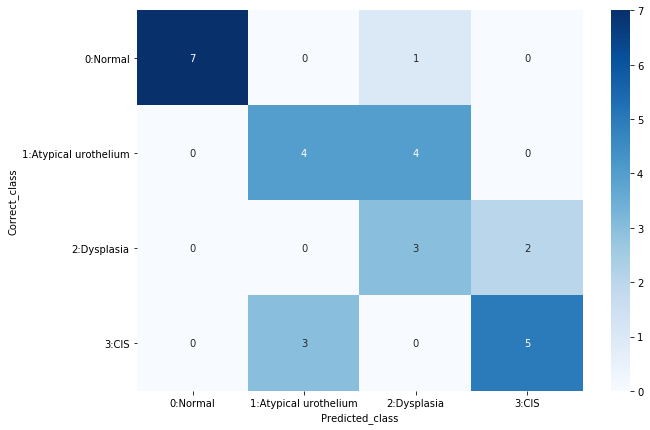

In [3]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------
lst = pd.read_csv("result_integration_4class_multi_400.csv" ).values.tolist()
#----------------------------------------------------------------------------
label_class = []
for i in range(len(lst)):
  if "N" in lst[i][0] :
    label_class.append("0:Normal")
  elif "A" in lst[i][0] :
    label_class.append("1:Atypical urothelium")
  elif "D" in lst[i][0] :
    label_class.append("2:Dysplasia")
  elif "C" in lst[i][0] :
    label_class.append("3:CIS")
  else:
    print("error")

score = []
for i in range(len(lst)):
  if lst[i][1] > lst[i][2] and lst[i][1] > lst[i][3] and lst[i][1] > lst[i][4] :
    score.append("0:Normal")
  elif lst[i][2] > lst[i][1] and lst[i][2] > lst[i][3] and lst[i][2] > lst[i][4] :
    score.append("1:Atypical urothelium")
  elif lst[i][3] > lst[i][1] and lst[i][3] > lst[i][2] and lst[i][3] > lst[i][4] :
    score.append("2:Dysplasia")
  elif lst[i][4] > lst[i][1] and lst[i][4] > lst[i][2] and lst[i][4] > lst[i][3] :
    score.append("3:CIS")
  else:
    print(str(lst[i][0]))


def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.savefig("result_integration_4class_multi_400.tiff", format="tiff", dpi=300)
    plt.show()
    

print(label_class)
print(score)

print_cmx(label_class, score)


max で統合

['N2_9_', 'C_219', 'A_226', 'D_213', 'C_226', 'N2_13', 'A_229', 'C_224', 'N2_14', 'D_206', 'N2_15', 'A_228', 'N2_11', 'C_225', 'A_231', 'D_212', 'D_214', 'C_223', 'N2_16', 'C_222', 'N2_10', 'C_220', 'C_221', 'N2_12', 'A_224', 'A_230', 'D_208', 'A_227', 'A_225']
Completed.
['0', '3', '1', '2', '3', '0', '1', '3', '0', '2', '0', '1', '0', '3', '1', '2', '2', '3', '0', '3', '0', '3', '3', '0', '1', '1', '2', '1', '1']


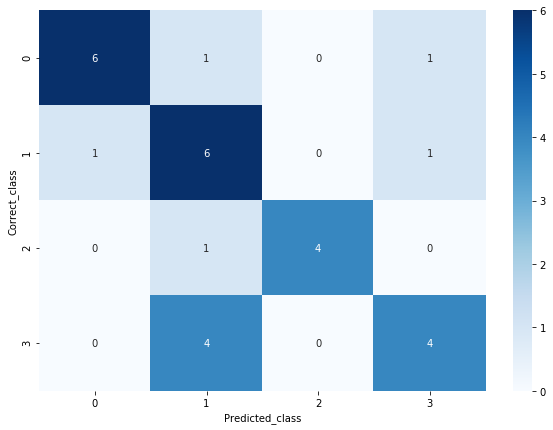

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

lst = pd.read_csv("result_400.csv").values.tolist()

name_val = []
for i in range(len(lst)):
  lst_name = lst[i][0]
  name_val.append(lst_name[0:5])
name_val = list(set(name_val))
print(name_val)

val_score = np.empty((len(name_val)+1,5),dtype='U100')
val_score[0,0] = "name"
val_score[0,1] = 'Normal'
val_score[0,2] = "Atypical"
val_score[0,3] = "Dysplasia"
val_score[0,4] = "CIS"

num_array = []
N_array = []
A_array = []
D_array = []
C_array = []

for i in range(len(name_val)):
  num_array.append(0)
for i in range(len(name_val)):
  N_array.append(0)
for i in range(len(name_val)):
  A_array.append(0)
for i in range(len(name_val)):
  D_array.append(0)
for i in range(len(name_val)):
  C_array.append(0)


for i in range(len(lst)):
  for j in range(len(name_val)):
    if name_val[j] in lst[i][0]:
      save_index = j
  num_array[save_index] += 1

  if N_array[save_index] < lst[i][1]:
    N_array[save_index] = lst[i][1]
  if A_array[save_index] < lst[i][2]:
    A_array[save_index] = lst[i][2]
  if D_array[save_index] < lst[i][3]:
    D_array[save_index] = lst[i][3]
  if C_array[save_index] < lst[i][4]:
    C_array[save_index] = lst[i][4]


for i in range(len(name_val)):
  N = N_array[i]
  A = A_array[i]
  D = D_array[i]
  C = C_array[i]

  val_score[i+1,0] = name_val[i]
  val_score[i+1,1] = str(N)
  val_score[i+1,2] = str(A)
  val_score[i+1,3] = str(D)
  val_score[i+1,4] = str(C)

np.savetxt("result_integration_max_4class_400.csv" ,val_score ,delimiter=',',fmt='%s')
print("Completed.")


import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

lst = pd.read_csv("result_integration_max_4class_400.csv" ).values.tolist()

label_class = []
for i in range(len(lst)):
  if "N" in lst[i][0] :
    label_class.append("0")
  elif "A" in lst[i][0] :
    label_class.append("1")
  elif "D" in lst[i][0] :
    label_class.append("2")
  elif "C" in lst[i][0] :
    label_class.append("3")
  else:
    print("error")

score = []
for i in range(len(lst)):
  if lst[i][1] > lst[i][2] and lst[i][1] > lst[i][3] and lst[i][1] > lst[i][4] :
    score.append("0")
  elif lst[i][2] > lst[i][1] and lst[i][2] > lst[i][3] and lst[i][2] > lst[i][4] :
    score.append("1")
  elif lst[i][3] > lst[i][1] and lst[i][3] > lst[i][2] and lst[i][3] > lst[i][4] :
    score.append("2")
  elif lst[i][4] > lst[i][1] and lst[i][4] > lst[i][2] and lst[i][4] > lst[i][3] :
    score.append("3")
  else:
    print(str(lst[i][0]))


def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cmx, cmap="Blues", annot=True)
    plt.xlabel("Predicted_class")
    plt.ylabel("Correct_class")
    plt.show()

print(label_class)

print_cmx(label_class, score)
